# Import Packages and Load Datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import seaborn as sns

import datetime

import librosa as lr
from librosa.core import stft, amplitude_to_db
from librosa.display import specshow
from glob import glob

from sklearn.model_selection import cross_val_score, train_test_split, ShuffleSplit, TimeSeriesSplit
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import r2_score
from sklearn.utils import resample

from functools import partial

import warnings
warnings.filterwarnings("ignore")

sns.set_style('ticks', rc={"xtick.direction": "in", "ytick.direction": "in"})
%matplotlib inline

In [2]:
''' data directories '''

datadir = '../datasets/raw'
datadir_pr = '../datasets/processed'

datadir_audio = '../datasets/audio/set_a'

In [3]:
prices0 = pd.read_csv(os.path.join(datadir,'prices.csv'), index_col=0, parse_dates=True)

In [4]:
prices = pd.read_csv(os.path.join(datadir_pr,'prices.csv'), index_col=0, parse_dates=True)
prices1 = pd.read_csv(os.path.join(datadir_pr,'prices1.csv'), index_col=0, parse_dates=True)
all_prices = pd.read_csv(os.path.join(datadir_pr,'prices2.csv'), index_col=0, parse_dates=True)
prices_impute = pd.read_csv(os.path.join(datadir_pr,'prices_impute.csv'), index_col=0, parse_dates=True)

normal = pd.read_csv(os.path.join(datadir_pr,'audio_normal.csv'), index_col='time')
abnormal = pd.read_csv(os.path.join(datadir_pr,'audio_abnormal.csv'), index_col='time')
audio0 = pd.read_csv(os.path.join(datadir_pr,'audio.csv'), index_col='time')

X_boot = pd.read_csv(os.path.join(datadir_pr,'cv_time_X.csv'), index_col=0).to_numpy()
y_boot = pd.read_csv(os.path.join(datadir_pr,'cv_time_y.csv'), index_col=0).to_numpy()

# Time Series and Machine Learning Primer

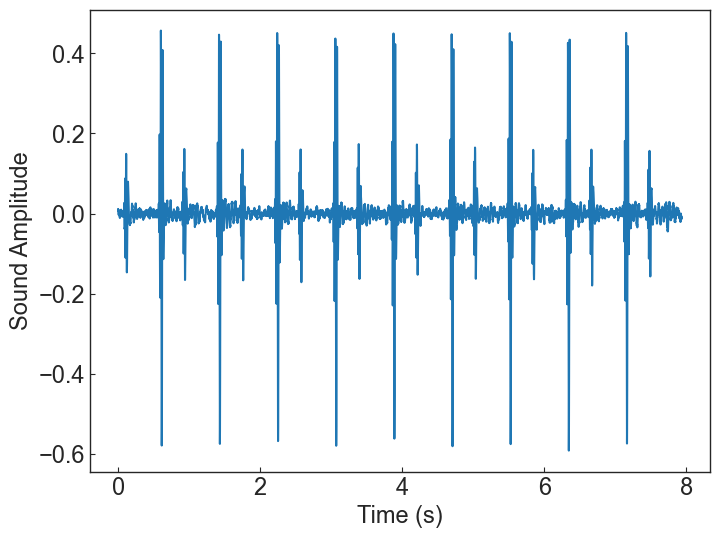

In [13]:
# List all the wav files in the folder
audio_files = glob(datadir_audio + '/*.wav')

# Read in the first audio file, create the time array
audio, sfreq = lr.load(audio_files[0])
time = np.arange(0, len(audio)) / sfreq

# Plot audio over time
fig, ax = plt.subplots()
ax.plot(time, audio)
ax.set(xlabel='Time (s)', ylabel='Sound Amplitude');

In [14]:
print(sfreq)

22050


In [15]:
print(len(audio))

174979


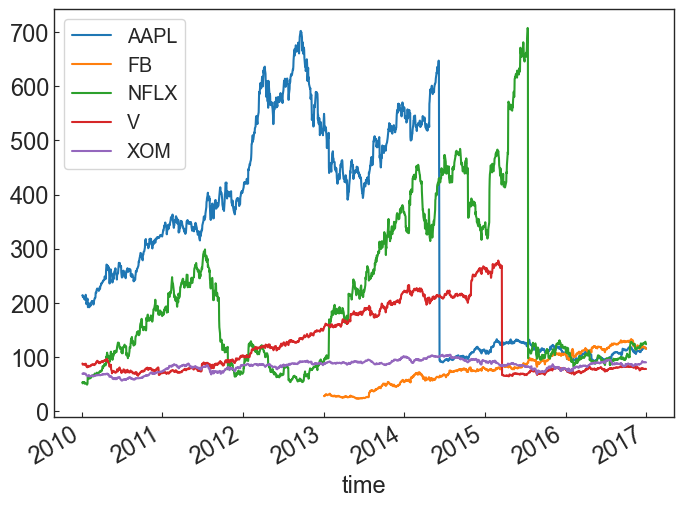

In [16]:
# Loop through each column, plot its values over time
fig, ax = plt.subplots()
for column in prices.columns:
    prices[column].plot(ax=ax, label=column)
    
ax.legend(loc='upper left', fontsize='small');

# Time Series as Inputs to a Model 

## Repetitions of sounds

- averaging across dimensions of a dataset and visually inspecting the result.

In [17]:
np.shape(normal)

(8820, 3)

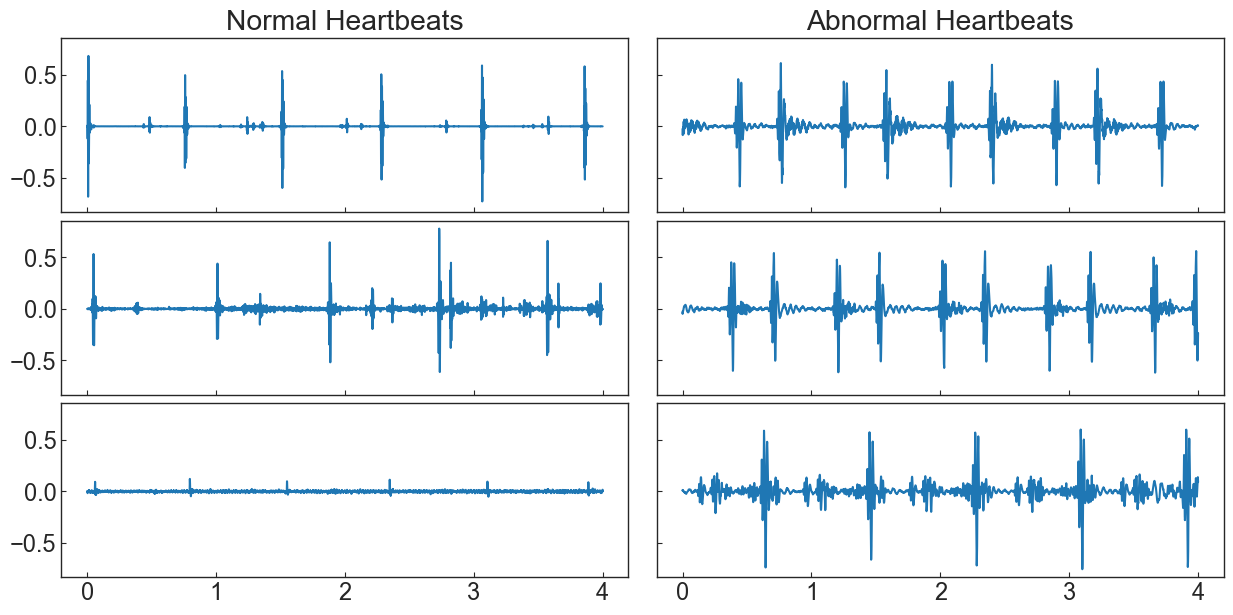

In [18]:
sfreq = 2205  # sampling frequency

fig, axs = plt.subplots(3, 2, figsize=(15, 7), sharex=True, sharey=True)

# Calculate the time array
time = np.arange(0, np.shape(normal)[0]) / sfreq

# Stack the normal/abnormal audio so you can loop and plot
stacked_audio = np.hstack([normal, abnormal]).T

n_audio = np.shape(normal)[1]
# Loop through each audio file / ax object and plot
# .T.ravel() transposes the array, then unravels it into a 1-D vector for looping
ii = 0
for iaudio, ax in zip(stacked_audio, axs.T.ravel()):
    ax.plot(time, iaudio)
    if ii==0: ax.set(title='Normal Heartbeats')
    if ii==n_audio: ax.set(title='Abnormal Heartbeats')
    ii += 1
    
fig.subplots_adjust(wspace=0.05, hspace=0.05)

## Invariance in time
- Data is usually noisy or exhibits complex patterns that aren't discoverable by the naked eye.
- find simple differences between two sets of data is to average across multiple instances of the same class. -> may remove noise and reveal underlying patterns (or, it may not).

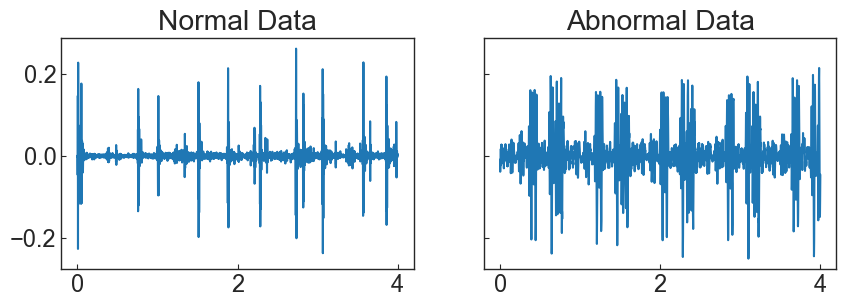

In [19]:
# Average across the audio files of each DataFrame
mean_normal = np.mean(normal, axis=1)
mean_abnormal = np.mean(abnormal, axis=1)

# Plot each average over time
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
ax1.plot(time, mean_normal)
ax1.set(title="Normal Data")
ax2.plot(time, mean_abnormal)
ax2.set(title="Abnormal Data");

## Calculating the envelope of sound

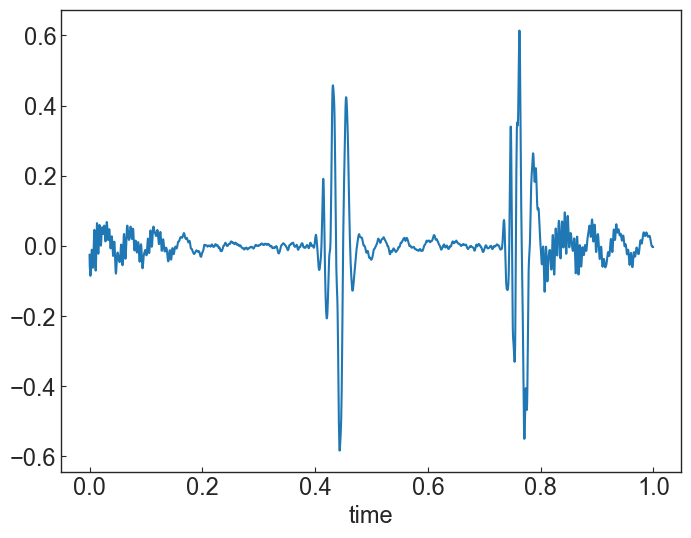

In [20]:
# Plot the raw data first
audio0.plot(legend=False);

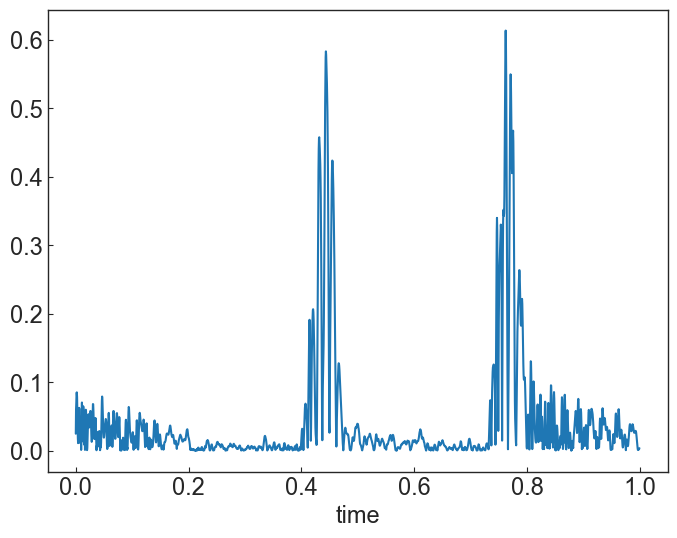

In [21]:
# Rectify the audio signal
audio_rectified = audio0.apply(np.abs)

# Plot the result
audio_rectified.plot(legend=False);

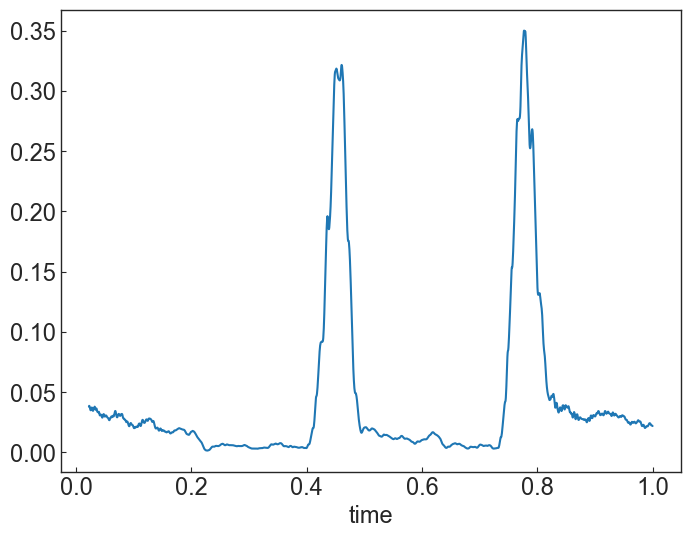

In [22]:
# Smooth by applying a rolling mean
audio_rectified_smooth = audio_rectified.rolling(50).mean().dropna()

# Plot the result
audio_rectified_smooth.plot(legend=False);

## Spectograms of heartbeat audio

In [23]:
HOP_LENGTH=16

normal1 = normal.loc[:,'3'].to_numpy()
# Prepare the STFT
HOP_LENGTH = 2**4
spec = stft(normal1, hop_length=HOP_LENGTH, n_fft=2**7)

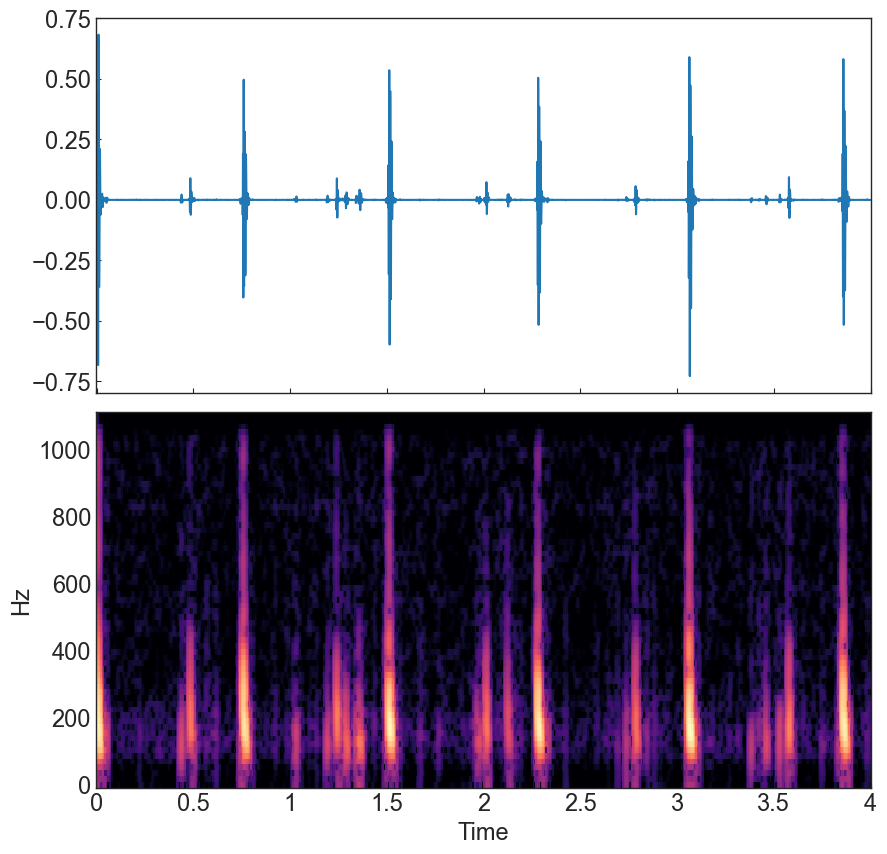

In [24]:
sfreq = 2205
time = np.arange(0, len(normal1)) / sfreq

# Convert into decibels
spec_db = amplitude_to_db(spec)

# Compare the raw audio to the spectrogram of the audio
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
axs[0].plot(time, normal1)
specshow(spec_db, sr=sfreq, x_axis='time', y_axis='hz', hop_length=HOP_LENGTH, ax=axs[1])

fig.subplots_adjust(hspace=0.05);

### Engineering spectral features

<div class='alert alert-danger'>
spec is imaginary quantity while spectral_bandwidth requires real values
</div>

# Predicting Time Series Data

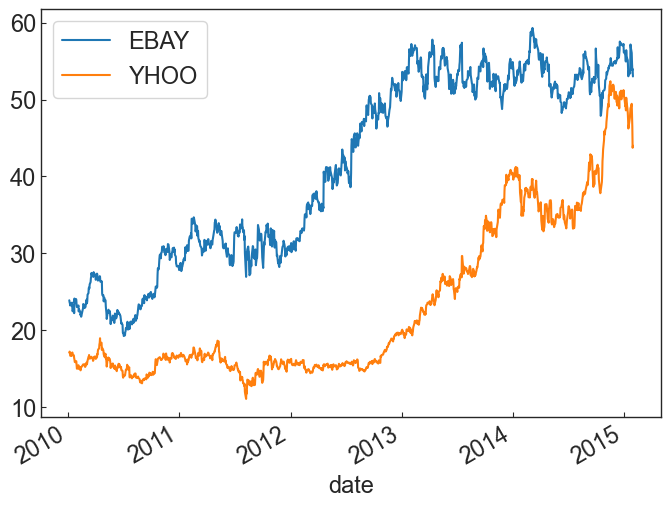

In [25]:
prices1.plot();

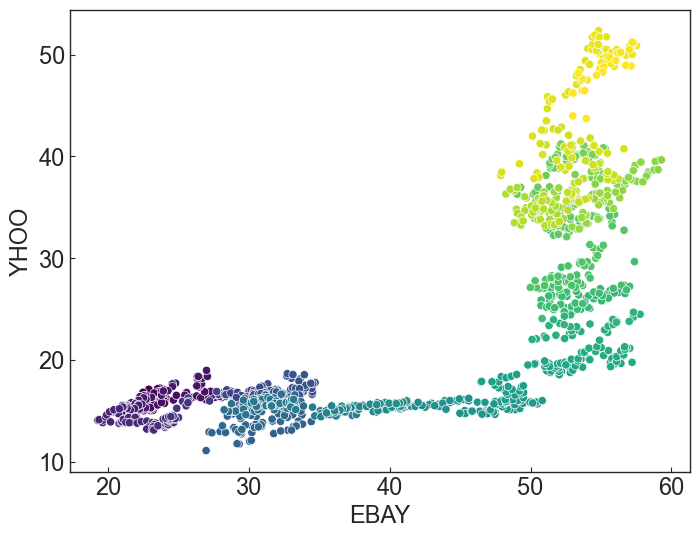

In [26]:
# Scatterplot with one company per axis
sns.scatterplot(x='EBAY', y='YHOO', data=prices1, c=prices1.index, cmap=plt.cm.viridis);
#prices1.plot.scatter(x='EBAY', y='YHOO');

## Fitting a simple regression model

In [27]:
# Use stock symbols to extract training data
X = all_prices[["EBAY", "NVDA", "YHOO"]]
y = all_prices[["AAPL"]]

# Fit and score the model with cross-validation
scores = cross_val_score(Ridge(), X, y, cv=3)
print(scores)

[-6.09050633 -0.3179172  -3.72957284]


### Messy data

In [28]:
prices2 = all_prices[['EBAY','NVDA','YHOO']].copy()

In [29]:
prices2.head()

,EBAY,NVDA,YHOO
date,,,
2010-01-04,23.900000,18.490000,17.100000
2010-01-05,23.650000,18.760000,17.230000
2010-01-06,23.500000,18.879999,17.170000
2010-01-07,23.229998,18.510000,16.700001
2010-01-08,23.509999,18.549999,16.700001


EBAY    0
NVDA    0
YHOO    0
dtype: int64


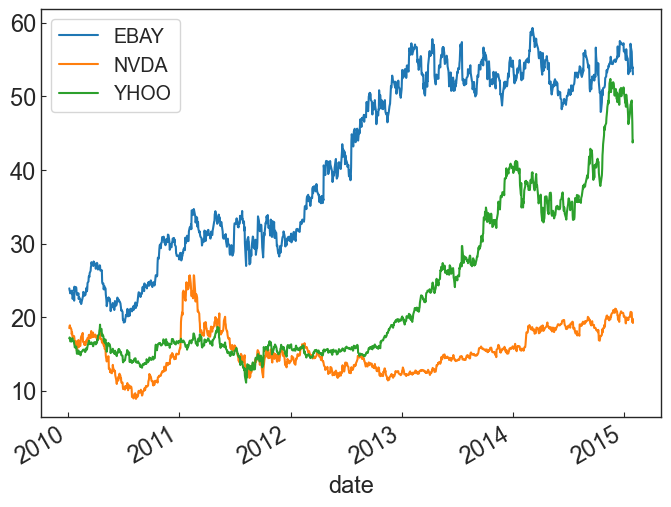

In [30]:
fig, ax = plt.subplots()
# Visualize the dataset
prices2.plot(ax=ax)
ax.legend(loc='upper left', fontsize='small');

# Count the missing values of each time series
missing_values = prices2.isna().sum()
print(missing_values)

### Imputing missing values

In [31]:
# Create a function we'll use to interpolate and plot
def interpolate_and_plot(prices, interpolation):

    # Create a boolean mask for missing values
    missing_values = prices.isna()

    # Interpolate the missing values
    prices_interp = prices.interpolate(interpolation)

    # Plot the results, highlighting the interpolated values in black
    fig, ax = plt.subplots(figsize=(10, 5))
    prices_interp.plot(color='k', alpha=.6, ax=ax, legend=False)
    
    # Now plot the interpolated values on top in red
    prices_interp[missing_values].plot(ax=ax, color='r', lw=3, legend=False)

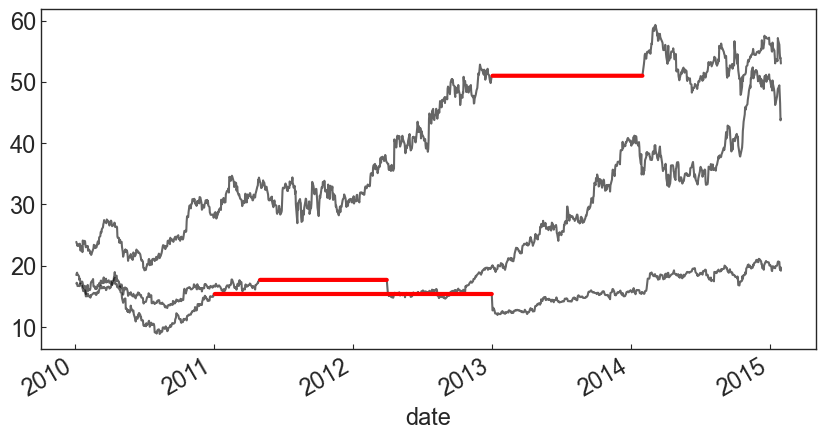

In [32]:
# Interpolate using the latest non-missing value
interpolation_type = 'zero'
interpolate_and_plot(prices_impute, interpolation_type)

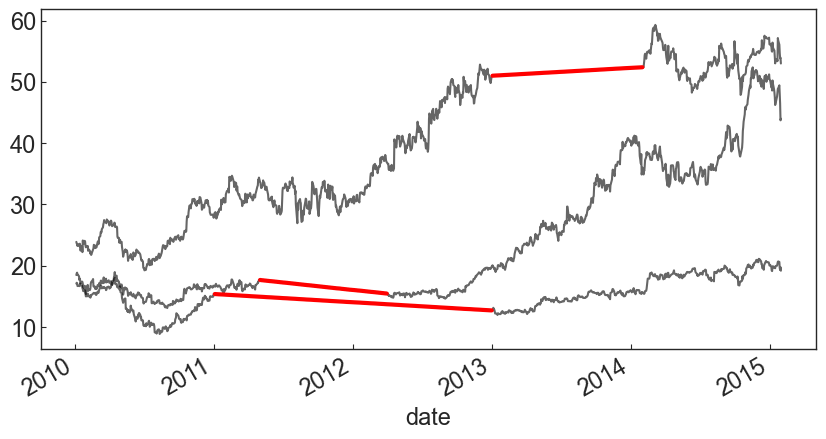

In [33]:
# Interpolate linearly
interpolation_type = 'linear'
interpolate_and_plot(prices_impute, interpolation_type)

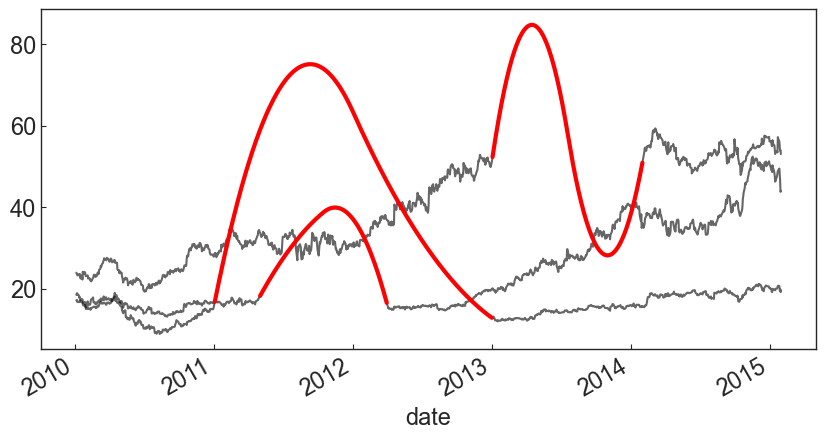

In [34]:
# Interpolate with a quadratic function
interpolation_type = 'quadratic'
interpolate_and_plot(prices_impute, interpolation_type)

### Transforming raw data

- the percent change of the latest data point from the mean of a window of previous data points

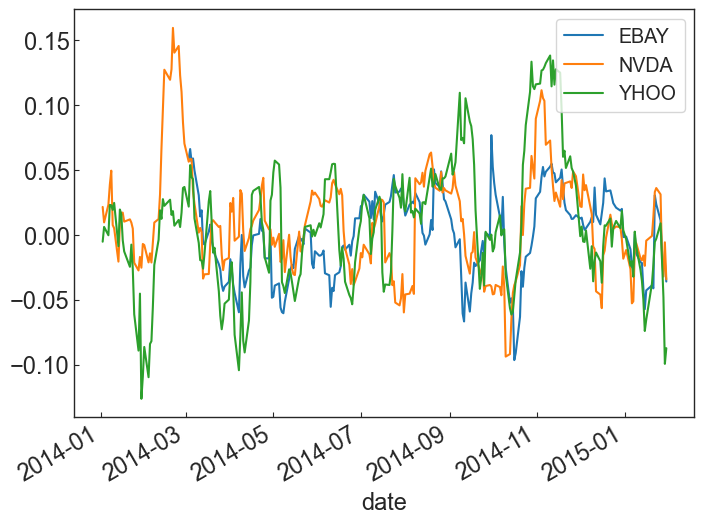

In [35]:
# Your custom function
def percent_change(series):
    # Collect all *but* the last value of this window, then the final value
    previous_values = series[:-1]
    last_value = series[-1]

    # Calculate the % difference between the last value and the mean of earlier values
    percent_change = (last_value - np.mean(previous_values)) / np.mean(previous_values)
    return percent_change

fig, ax = plt.subplots()
# Apply your custom function and plot
prices_perc = prices_impute.rolling(20).aggregate(percent_change)
prices_perc.loc["2014":"2015"].plot(ax=ax)
ax.legend(loc='upper right', fontsize='small');

## Handling Outliers

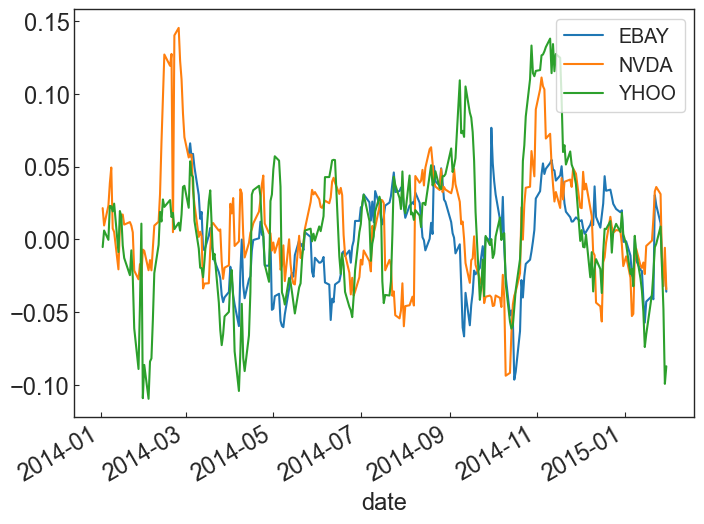

In [36]:
def replace_outliers(series):
    # Calculate the absolute difference of each timepoint from the series mean
    absolute_differences_from_mean = np.abs(series - np.mean(series))
    
    # Calculate a mask for the differences that are > 3 standard deviations from zero
    this_mask = absolute_differences_from_mean > (np.std(series) * 3)
    
    # Replace these values with the median accross the data
    series[this_mask] = np.nanmedian(series)
    return series

fig, ax = plt.subplots()
# Apply your preprocessing function to the timeseries and plot the results
prices_perc = prices_perc.aggregate(replace_outliers)
prices_perc.loc["2014":"2015"].plot(ax=ax)
ax.legend(loc='upper right', fontsize='small');

## Engineering multiple rolling features at once

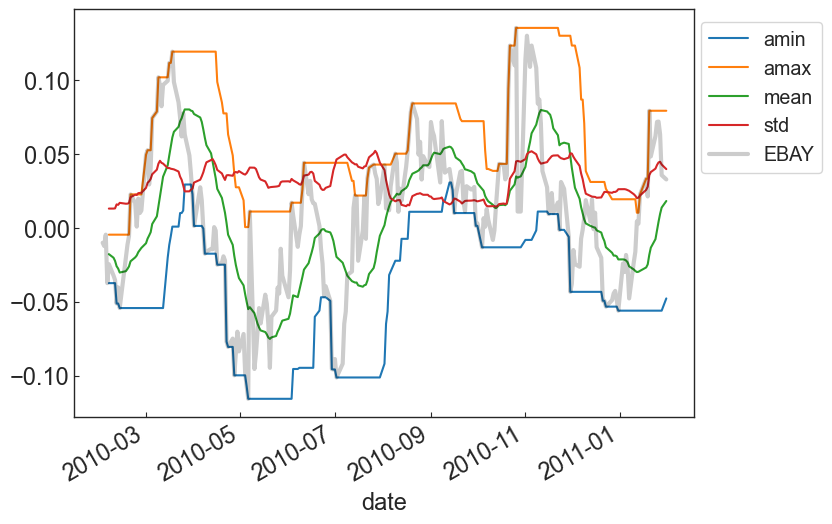

In [37]:
prices_perc2 = prices_perc['EBAY'].copy()

# Define a rolling window with Pandas, excluding the right-most datapoint of the window
prices_perc_rolling = prices_perc2.rolling(20, min_periods=5, closed='right')

# Define the features you'll calculate for each window
features_to_calculate = [np.min, np.max, np.mean, np.std]

# Calculate these features for your rolling window object
features = prices_perc_rolling.aggregate(features_to_calculate)

# Plot the results
ax = features.loc[:"2011-01"].plot()
prices_perc2.loc[:"2011-01"].plot(ax=ax, color='k', alpha=.2, lw=3)
ax.legend(loc=(1.01, .6), fontsize='small');

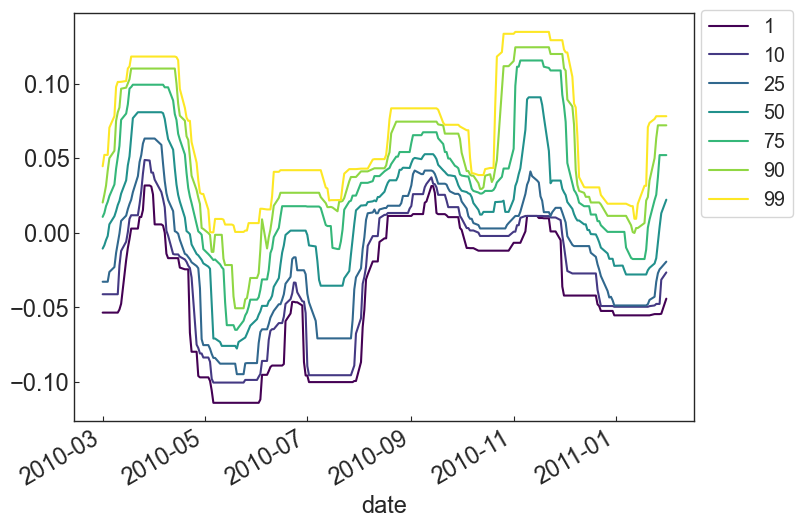

In [38]:
from functools import partial
percentiles = [1, 10, 25, 50, 75, 90, 99]

# Use a list comprehension to create a partial function for each quantile
percentile_functions = [partial(np.percentile, q=percentile) for percentile in percentiles]

# Calculate each of these quantiles on the data using a rolling window
prices_perc_rolling = prices_perc2.rolling(20, min_periods=5, closed='right')
features_percentiles = prices_perc_rolling.aggregate(percentile_functions)

# Plot a subset of the result
ax = features_percentiles.loc[:"2011-01"].plot(cmap=plt.cm.viridis)
ax.legend(percentiles, loc=(1.01, .5), fontsize='small');

## Using "date" information

In [39]:
prices_perc_df = prices_perc2.to_frame()

# Extract date features from the data, add them as columns
prices_perc_df['day_of_aweek']  = prices_perc_df.index.weekday
prices_perc_df['week_of_year']  = prices_perc_df.index.week
prices_perc_df['month_of_year'] = prices_perc_df.index.month

# Print prices_perc
prices_perc_df.sample(10)

,EBAY,day_of_aweek,week_of_year,month_of_year
date,,,,
2011-11-03,0.020924,3,44,11
2010-09-14,0.032655,1,37,9
2010-10-12,-0.001590,1,41,10
2014-05-12,-0.033879,0,20,5
2011-10-05,-0.016514,2,40,10
2012-04-02,-0.010757,0,14,4
2013-05-20,NaN,0,21,5
2012-04-27,0.103649,4,17,4
2013-02-04,NaN,0,6,2


# Validating and Inspecting Time Series Models

## Creating time-shifted features

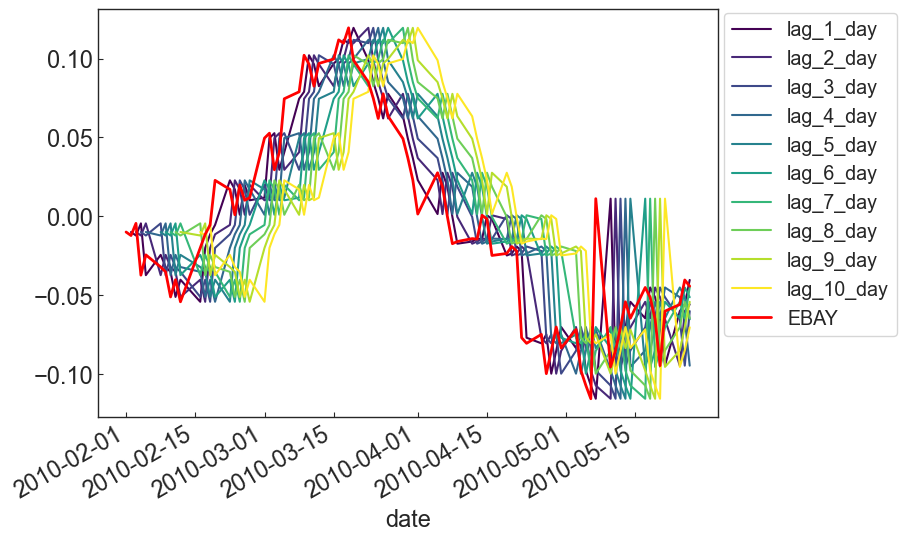

In [40]:
# These are the "time lags"
shifts = np.arange(1, 11).astype(int)

# Use a dictionary comprehension to create name: value pairs, one pair per shift
shifted_data = {"lag_{}_day".format(day_shift): prices_perc2.shift(day_shift) for day_shift in shifts}

# Convert into a DataFrame for subsequent use
prices_perc_shifted = pd.DataFrame(shifted_data)

# Plot the first 100 samples of each
ax = prices_perc_shifted.iloc[:100].plot(cmap=plt.cm.viridis)
prices_perc2.iloc[:100].plot(color='r', lw=2)
ax.legend(loc=(1.01, .2), fontsize='small');

## Auto-regressive model
- a regression model where the input features are time-shifted versions of the output time series data

In [41]:
# Replace missing values with the median for each column
X = prices_perc_shifted.fillna(np.nanmedian(prices_perc_shifted))
y = prices_perc2.fillna(np.nanmedian(prices_perc2))

# Fit the model
model = Ridge()
model.fit(X, y)

Ridge()

In [42]:
def visualize_coefficients(coefs, names, ax):
    # Make a bar plot for the coefficients, including their names on the x-axis
    ax.bar(names, coefs)
    ax.set(xlabel='Coefficient name', ylabel='Coefficient value')
    
    # Set formatting so it looks nice
    plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    return ax

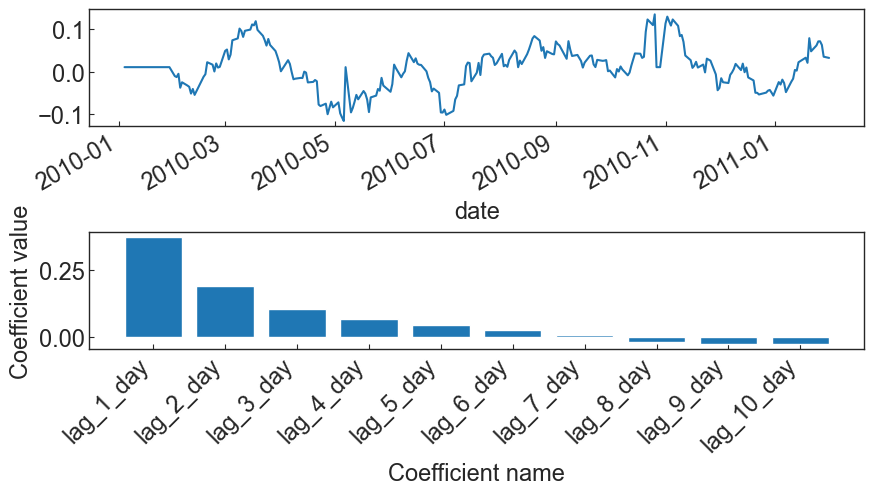

In [43]:
# Visualize the output data up to "2011-01"
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
y.loc[:'2011-01'].plot(ax=axs[0])

# Run the function to visualize model's coefficients
visualize_coefficients(model.coef_, prices_perc_shifted.columns, ax=axs[1])

fig.subplots_adjust(hspace=0.9);

## Bootstrapping a confidence interval

In [44]:
def bootstrap_interval(data, percentiles=(2.5, 97.5), n_boots=100):
    """Bootstrap a confidence interval for the mean of columns of a 1- or 2-D dataset."""
    # Create our empty array we'll fille with the results
    if data.ndim == 1:
        data = data[:, np.newaxis]
    data = np.atleast_2d(data)
    bootstrap_means = np.zeros([n_boots, data.shape[-1]])
    for ii in range(n_boots):
        # Generate random indices for our data *with* replacement, then take the sample mean
        random_sample = resample(data)
        bootstrap_means[ii] = random_sample.mean(axis=0)

    # Compute the percentiles of choice for the bootstrapped means
    percentiles = np.percentile(bootstrap_means, percentiles, axis=0)
    return percentiles

In [45]:
# Iterate through CV splits
n_splits = 100
cv = TimeSeriesSplit(n_splits=n_splits)

model = LinearRegression()

# Create empty array to collect coefficients
coefficients = np.zeros([n_splits, X_boot.shape[1]])

for ii, (tr, tt) in enumerate(cv.split(X_boot, y_boot)):
    # Fit the model on training data and collect the coefficients
    model.fit(X_boot[tr], y_boot[tr])
    coefficients[ii] = model.coef_

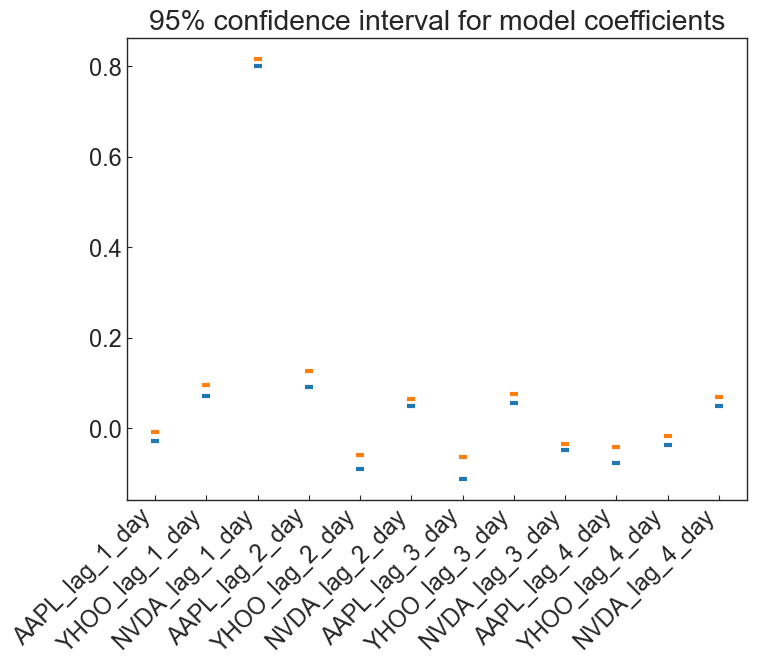

In [46]:
feature_names= ['AAPL_lag_1_day', 'YHOO_lag_1_day', 'NVDA_lag_1_day', 'AAPL_lag_2_day', \
                'YHOO_lag_2_day', 'NVDA_lag_2_day', 'AAPL_lag_3_day', 'YHOO_lag_3_day', \
                'NVDA_lag_3_day', 'AAPL_lag_4_day', 'YHOO_lag_4_day', 'NVDA_lag_4_day']
# Calculate a confidence interval around each coefficient
bootstrapped_interval = bootstrap_interval(coefficients, percentiles=(2.5, 97.5), n_boots=100)

# Plot it
fig, ax = plt.subplots()
ax.scatter(feature_names, bootstrapped_interval[0], marker='_', lw=3)
ax.scatter(feature_names, bootstrapped_interval[1], marker='_', lw=3)
ax.set(title='95% confidence interval for model coefficients')
plt.setp(ax.get_xticklabels(), rotation=45, horizontalalignment='right');

In [47]:
print(np.shape(bootstrapped_interval))

(2, 12)


In [48]:
def my_pearsonr(est, X, y):
    return np.corrcoef(est.predict(X).squeeze(), y.squeeze())[1, 0]

In [49]:
times_scores = ['2010-04-05', '2010-04-28', '2010-05-21', '2010-06-16', '2010-07-12', '2010-08-04', '2010-08-27', '2010-09-22', '2010-10-15', '2010-11-09', '2010-12-03', '2010-12-29', '2011-01-24',
               '2011-02-16', '2011-03-14', '2011-04-06', '2011-05-02', '2011-05-25', '2011-06-20', '2011-07-14', '2011-08-08', '2011-08-31', '2011-09-26', '2011-10-19', '2011-11-11', '2011-12-07',
               '2012-01-03', '2012-01-27', '2012-02-22', '2012-03-16', '2012-04-11', '2012-05-04', '2012-05-30', '2012-06-22', '2012-07-18', '2012-08-10', '2012-09-05', '2012-09-28', '2012-10-23',
               '2012-11-19', '2012-12-13', '2013-01-09', '2013-02-04', '2013-02-28', '2013-03-25', '2013-04-18', '2013-05-13', '2013-06-06', '2013-07-01', '2013-07-25', '2013-08-19', '2013-09-12',
               '2013-10-07', '2013-10-30', '2013-11-22', '2013-12-18', '2014-01-14', '2014-02-07', '2014-03-05', '2014-03-28', '2014-04-23', '2014-05-16', '2014-06-11', '2014-07-07', '2014-07-30',
               '2014-08-22', '2014-09-17', '2014-10-10', '2014-11-04', '2014-11-28', '2014-12-23', '2015-01-20', '2015-02-12', '2015-03-10', '2015-04-02', '2015-04-28', '2015-05-21', '2015-06-16',
               '2015-07-10', '2015-08-04', '2015-08-27', '2015-09-22', '2015-10-15', '2015-11-09', '2015-12-03', '2015-12-29', '2016-01-25', '2016-02-18', '2016-03-14', '2016-04-07', '2016-05-02',
               '2016-05-25', '2016-06-20', '2016-07-14', '2016-08-08', '2016-08-31', '2016-09-26', '2016-10-19', '2016-11-11', '2016-12-07']

In [50]:
# Generate scores for each split to see how the model performs over time
scores = cross_val_score(model, X_boot, y_boot, cv=cv, scoring=my_pearsonr)

# Convert to a Pandas Series object
scores_series = pd.Series(scores, index=times_scores, name='score')

# Bootstrap a rolling confidence interval for the mean score
scores_lo = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=2.5))
scores_hi = scores_series.rolling(20).aggregate(partial(bootstrap_interval, percentiles=97.5))

## Account for non-stationarity

In [51]:
# Pre-initialize window sizes
window_sizes = [25, 50, 75, 100]

# Create an empty DataFrame to collect the stores
all_scores = pd.DataFrame(index=times_scores)

# Generate scores for each split to see how the model performs over time
for window in window_sizes:
    # Create cross-validation object using a limited lookback window
    cv = TimeSeriesSplit(n_splits=100, max_train_size=window)
    
    # Calculate scores across all CV splits and collect them in a DataFrame
    this_scores = cross_val_score(model, X, y, cv=cv, scoring=my_pearsonr)
    all_scores['Length {}'.format(window)] = this_scores

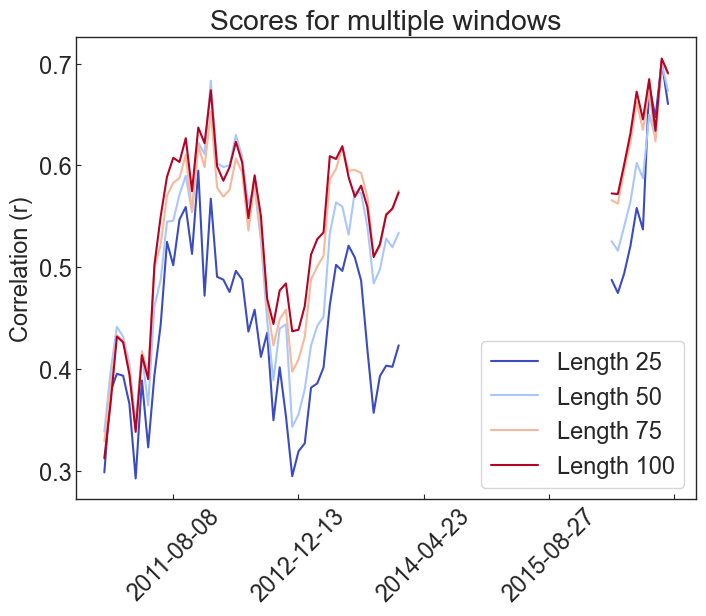

In [52]:
# Visualize the scores
ax = all_scores.rolling(10).mean().plot(cmap=plt.cm.coolwarm)
ax.set(title='Scores for multiple windows', ylabel='Correlation (r)')
ax.tick_params(axis='x', rotation=45);